In [1]:
using Plots, DifferentialEquations,Interpolations, Random, Distributions, NLopt, Dierckx, LaTeXStrings
gr()

Plots.GRBackend()

In [2]:
a=zeros(3)
J=1.0; D=1.0; k=1/10; σ=1.0/2;
x=LinRange(0,20,21); 
xx=LinRange(0,20,201);

In [3]:
function model(x,a)
y=zeros(length(x))
c(x) = a[1]*exp(-x*sqrt(a[3]/a[2]))/sqrt(a[2]*a[3])
    for i in 1:length(x) 
    y[i] = c(x[i])
    end 
return y
end

model (generic function with 1 method)

In [4]:
data=[ 3.898952675812746  
2.569825438525737  
1.206631819080483  
1.3543817108830818 
0.6175527058221386 
0.30785528929186456
0.13649714414672498
0.6921031114954066 
0.271392505145547  
0.0945662375934022 
0.06039757137011752
0.1338145218277993 
0.1529291485263356
0.05189445084962129
0.02756210195622014
0.018066943988933968
0.017710583152626524
0.009164129234587067
0.008075081582671598
0.010557776318846062
0.004853780605374777];

In [5]:
function loglhood(data,a,σ)
    y=zeros(length(x))
    y=model(x,a) # simulate deterministic model with parameters a
    ℓ=0;
    data_dists=[LogNormal(0,σ) for mi in y]; # LogNormal distribution
    ℓ+=sum([loglikelihood(data_dists[i],data[i]./y[i]) for i in 1:length(data_dists)])  
    return ℓ
end

loglhood (generic function with 1 method)

In [6]:
a=zeros(3)
function funmle(a)
return loglhood(data,a,σ)
end

funmle (generic function with 1 method)

In [7]:
function Optimise(fun,θ₀,lb,ub)    
    tomax=(θ,∂θ)->fun(θ)
    opt=Opt(:LN_NELDERMEAD,length(θ₀))
    opt.max_objective=tomax
    opt.lower_bounds=lb      
    opt.upper_bounds=ub
    opt.maxtime=1*60
    res = optimize(opt,θ₀)
    return res[[2,1]]
end

Optimise (generic function with 1 method)

  0.473700 seconds (1.55 M allocations: 84.207 MiB, 99.08% compilation time)


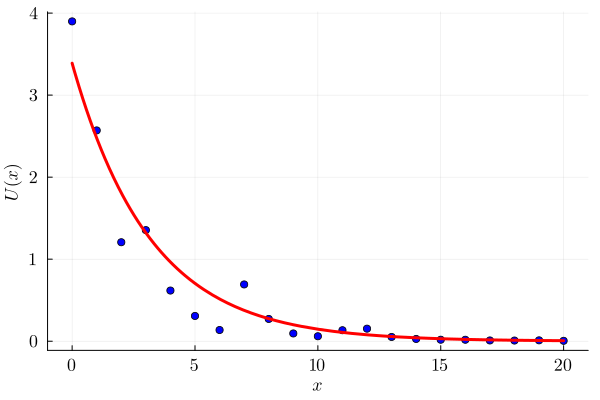

In [8]:
θG=[J, D, k]
lb=[0,0,0]
ub=[1000,1000,1000]
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub)
Jmle=xopt[1]
Dmle=xopt[2]
kmle=xopt[3]
fmle=fopt
cmle(x) =  xopt[1]*exp(-x*sqrt(xopt[3]/xopt[2]))/sqrt(xopt[2]*xopt[3])
p1=scatter(x,data,mc=:blue,msc=:match,label=false)
p1=plot!(cmle,xx[1],xx[end],color=:red,label=false,xlabel=L"x",ylabel=L"U(x)",xlims=(xx[1]-1,xx[end]+1),lw=3)
p1=plot!(xticks = ([0,5,10,15,20],  [L"0", L"5", L"10", L"15", L"20"]))
p1=plot!(yticks = ([0,1,2,3,4], [L"0", L"1", L"2", L"3", L"4"]))
p1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(p1)

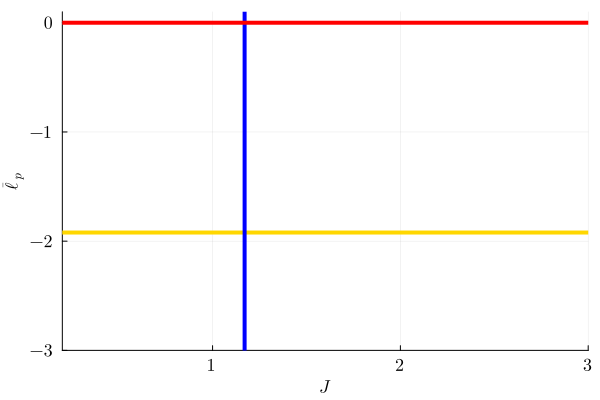

In [9]:
df=1
llstar=-quantile(Chisq(df),0.95)/2
function univariateJ(J)
    a=zeros(2)    
    function funJ(a)
    return loglhood(data,[J,a[1],a[2]],σ)
    end
    θG=[Dmle,kmle]
    lb=[0.0,0.0] 
    ub=[1000.0,1000] 
    (xopt,fopt)=Optimise(funJ,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariateJ(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=50;
Jrange=LinRange(0.2,3,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariateJ(Jrange[i])[1]
end

q1=hline([llstar],legend=false,lw=4,xlabel=L"J",ylabel=L"\bar{\ell}_p",color=:gold)
q1=vline!([Jmle],legend=false,lw=4,color=:blue)
spl=Spline1D(Jrange,ff.-maximum(ff),w=ones(length(Jrange)),k=1,bc="nearest",s=1/100)
yy=evaluate(spl,Jrange)
q1=plot!(Jrange,yy,lw=4,lc=:red,ylims=(-3,0.1),xlims=(Jrange[1],Jrange[end]))
q1=plot!(xticks=([1,2,3],[L"1", L"2", L"3"]))
q1=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q1)

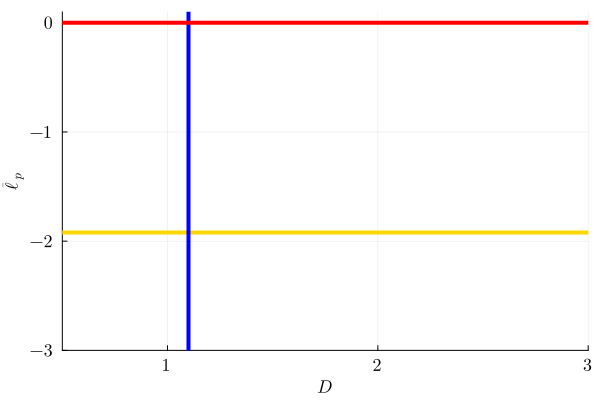

In [10]:
function univariateD(D)
    a=zeros(2)    
    function funD(a)
    return loglhood(data,[a[1],D,a[2]],σ)
    end
    θG=[Jmle,kmle]
    lb=[0.0,0.0] 
    ub=[10.0,100] 
    (xopt,fopt)=Optimise(funD,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariateD(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=40;
Drange=LinRange(0.5,3,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariateD(Drange[i])[1]
end


q2=hline([llstar],legend=false,lw=4,xlabel=L"D",ylabel=L"\bar{\ell}_p",color=:gold)
q2=vline!([Dmle],legend=false,lw=4,color=:blue)
spl=Spline1D(Drange,ff.-maximum(ff),w=ones(length(Drange)),k=1,bc="nearest",s=1/100)
yy=evaluate(spl,Drange)
q2=plot!(Drange,yy,lw=4,lc=:red,ylims=(-3,0.1),xlims=(Drange[1],Drange[end]))
q2=plot!(xticks=([1,2,3],[L"1", L"2", L"3"]))
q2=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q2)

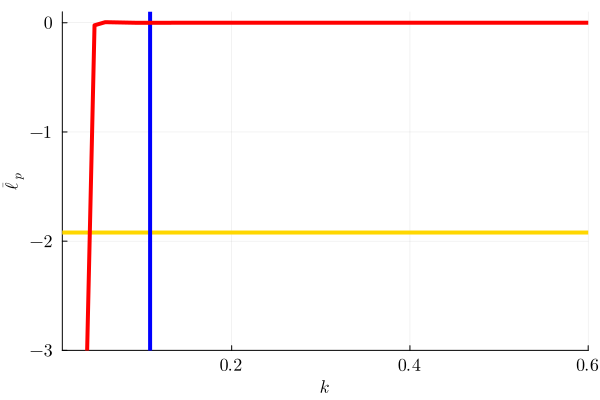

In [11]:
function univariatek(k)
    a=zeros(2)    
    function funk(a)
    return loglhood(data,[a[1],a[2],k],σ)
    end
    θG=[Jmle,Dmle]
    lb=[0.0,0.0] 
    ub=[1000.0,1000] 
    (xopt,fopt)=Optimise(funk,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariatek(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=50;
krange=LinRange(0.01,0.60,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariatek(krange[i])[1]
end

q3=hline([llstar],legend=false,lw=4,xlabel=L"k",ylabel=L"\bar{\ell}_p",color=:gold)
q3=vline!([kmle],legend=false,lw=4,color=:blue)
spl=Spline1D(krange,ff.-maximum(ff),w=ones(length(krange)),k=1,bc="nearest",s=1/100)
yy=evaluate(spl,krange)
q3=plot!(krange,yy,lw=4,lc=:red,ylims=(-3,0.1),xlims=(krange[1],krange[end]))
q3=plot!(xticks=([0.2, 0.4, 0.6],[L"0.2", L"0.4", L"0.6"]))
q3=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q3=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q3)

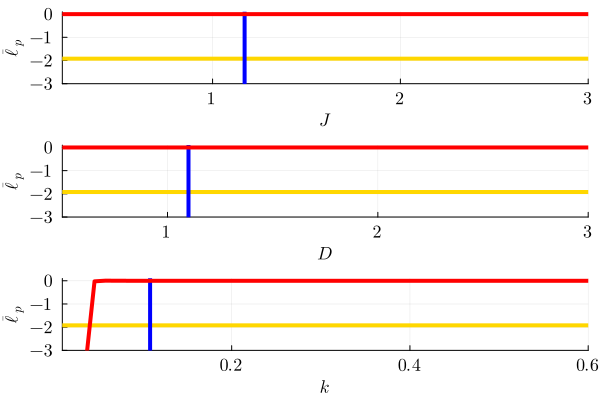

In [12]:
q4=plot(q1,q2,q3,layout=(3,1))

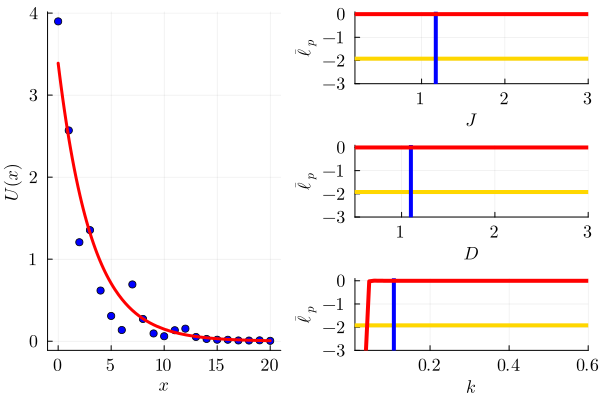

In [13]:
q5=plot(p1,q4,layout=(1,2))